In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from rdkit import Chem

from pipeline import mini_algo
from utils import draw_mols_with_highlight

/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jackie16201/Desktop/Spring_2023/fragments_discovery_design_ML/src/pipeline.py:11: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  from rdkit.Chem import MCS


# Part 1: Process SA scores (mini version of fragment algorithm)

In [2]:
# Values for processing fragments and compounds
fragment_path = '../out/model_preds_on_frags_and_cpds/SA/FINISHED_combined_fragment_preds_05_24_2022.csv'
compound_path = '../out/model_preds_on_frags_and_cpds/SA/combined_broad_preds_05_20_2022.csv'
result_path = '../out/controls/exploratory_scatterplot_SA_'
fragment_smi_col = 'SMILES'
compound_smi_col = 'smiles'
fragment_hit_col = 'ACTIVITY'
compound_hit_col = 'ACTIVITY'

# filters and thresholds for fragments and compounds
fragment_score = 0.05
compound_score = 0.05
fragment_remove_pains_brenk = 'both' # one of 'both', 'pains', 'brenk', 'none'
compound_remove_pains_brenk = 'both' # one of 'both', 'pains', 'brenk', 'none'
fragment_require_more_than_coh = False

In [3]:
rank_df, _ = mini_algo(fragment_path=fragment_path,
                    compound_path=compound_path,
                    result_path=result_path,
                    fragment_smi_col=fragment_smi_col,
                    compound_smi_col=compound_smi_col,
                    fragment_hit_col=fragment_hit_col,
                    compound_hit_col=compound_hit_col,
                    fragment_score=fragment_score,
                    compound_score=compound_score,
                    fragment_remove_pains_brenk=fragment_remove_pains_brenk,
                    compound_remove_pains_brenk=compound_remove_pains_brenk, 
                    fragment_require_more_than_coh=fragment_require_more_than_coh) # should be 333 matching



Processing fragments...
length of df:  27523571
length of df >0.05:  238434
length of df with valid mols:  238434
length of all preds with clean (no PAINS or Brenk) mols:  81864

Processing compounds...
length of df:  799147
length of df >0.05:  145076
length of df with valid mols:  145076
length of all preds with clean (no PAINS or Brenk) mols:  86723

Matching fragments in compounds...
number of matched fragments:  333
Previewing dataframe so far...


,matched_fragments,fragment_SMILES,length_of_fragment,matched_molecules,number_of_matched_molecules,fragment_scores,full_molecule_scores,average_molecule_score
331,81857,ClC1=CC=CC=C1Cl,8,"[17, 20, 151, 177, 273, 293, 331, 548, 599, 60...",1811,0.252329,"[0.1128936884924769, 0.0507392316823895, 0.178...",0.137416
10,1496,CCCc1ccc(O)cc1,10,"[0, 9, 24, 96, 148, 153, 165, 184, 185, 215, 2...",1586,0.070360,"[0.203643961623311, 0.1748821657150983, 0.0552...",0.105328
5,449,CCCc1cccc(O)c1,10,"[8, 9, 127, 145, 151, 175, 235, 237, 243, 476,...",953,0.065105,"[0.3121060699224472, 0.1748821657150983, 0.198...",0.103804
104,42396,CCCCc1ccc(O)cc1,11,"[0, 9, 24, 96, 148, 153, 165, 184, 215, 232, 2...",933,0.108027,"[0.203643961623311, 0.1748821657150983, 0.0552...",0.105258
323,81806,CC1=CC=C(Cl)C(Cl)=C1,9,"[17, 20, 273, 293, 599, 600, 1366, 1368, 1375,...",791,0.083356,"[0.1128936884924769, 0.0507392316823895, 0.087...",0.128110


# Part 2: Plot SA scores with hardcoded examples

In [4]:
# get all frag and mol scores
frag_scos = []
mol_scos = []

for i,row in rank_df.iterrows():
    frag_sco = float(row['fragment_scores'])
    full_mol_scos = list(row['full_molecule_scores'])
    frag_scos.extend([frag_sco] * len(full_mol_scos))
    mol_scos.extend(full_mol_scos)

In [10]:
# hardcoded examples of a successful and unsuccessful compound with scores
success_mol = Chem.MolFromSmiles('COc1ccc2[nH]cc(c2c1)CCNC(=O)Nc1ccc(c(c1)Cl)Cl') # BRD-K39227016
success_mol_score = 0.2386302828788757 

fail_mol = Chem.MolFromSmiles('CCCC1=CC(=O)N=C(N1)SCC(=O)Nc1ccc(c(c1)Cl)Cl') # BRD-K23971431
fail_mol_score = 0.1560791455209255

frag = 'CNC1=CC=C(Cl)C(Cl)=C1'
draw_mols_with_highlight([success_mol], frag, legends=['BRD-K39227016: ' + str(np.round(success_mol_score, 3))], file_path=result_path + 'success_example.png')
draw_mols_with_highlight([fail_mol], frag, legends=['BRD-K23971431: ' + str(np.round(fail_mol_score, 3))], file_path=result_path + 'fail_example.png')

# add the success/fail mols as examples
EX_frag_scos = [0.1714286329806782] * 2 # fragment score
EX_mol_scos = [success_mol_score, fail_mol_score]

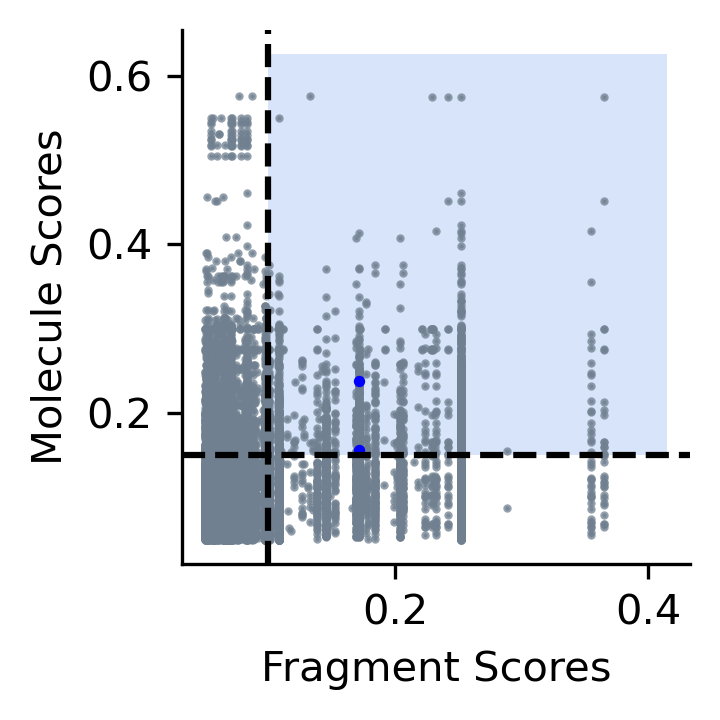

In [11]:
fig, ax = plt.subplots(figsize = (2.5,2.5), dpi = 300)
rect = patches.Rectangle((0.1, 0.15), max(frag_scos)-0.1+0.05,max(mol_scos)-0.15+0.05, alpha = 0.25, linewidth=1, facecolor='cornflowerblue')
plt.axvline(0.1, color = 'black', linestyle = '--')
plt.axhline(0.15, color = 'black', linestyle = '--')
ax.add_patch(rect)

plt.scatter(frag_scos, mol_scos, alpha = 0.75, s=1, color = 'slategrey')
plt.scatter(EX_frag_scos, EX_mol_scos, alpha = 1, s=3, color = 'blue')

plt.xlabel('Fragment Scores')
plt.ylabel('Full Compound Scores')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('../figure_panels/scatter_frag_vs_cpd_scores_SA.png')
plt.savefig('../figure_panels/scatter_frag_vs_cpd_scores_SA.svg')
plt.show()

# Part 3: Process NG scores

In [2]:
# Values for processing fragments and compounds
fragment_path = '../out/model_preds_on_frags_and_cpds/NG/enamine_frags_18mil_with_FINALbayHO11152022_melis_predictions_11_18_2022.csv'
compound_path = '../out/model_preds_on_frags_and_cpds/NG/broad800K_melis_predictions_with_FINALbayHO11152022_11_16_2022.csv'
result_path = '../out/controls/exploratory_scatterplot_NG_'
fragment_smi_col = 'smiles'
compound_smi_col = 'smiles'
fragment_hit_col = 'hit'
compound_hit_col = 'hit'

# filters and thresholds for fragments and compounds
fragment_score = 0.1
compound_score = 0.3
fragment_remove_pains_brenk = 'both' # one of 'both', 'pains', 'brenk', 'none'
compound_remove_pains_brenk = 'both' # one of 'both', 'pains', 'brenk', 'none'
fragment_require_more_than_coh = False

rank_df, _ = mini_algo(fragment_path=fragment_path,
                    compound_path=compound_path,
                    result_path=result_path,
                    fragment_smi_col=fragment_smi_col,
                    compound_smi_col=compound_smi_col,
                    fragment_hit_col=fragment_hit_col,
                    compound_hit_col=compound_hit_col,
                    fragment_score=fragment_score,
                    compound_score=compound_score,
                    fragment_remove_pains_brenk=fragment_remove_pains_brenk,
                    compound_remove_pains_brenk=compound_remove_pains_brenk, 
                    fragment_require_more_than_coh=fragment_require_more_than_coh)



Processing fragments...
length of df:  18338026
length of df >0.1:  198303
length of df with valid mols:  198303
length of all preds with clean (no PAINS or Brenk) mols:  198303

Processing compounds...
length of df:  799147
length of df >0.3:  29654
length of df with valid mols:  29654
length of all preds with clean (no PAINS or Brenk) mols:  6420

Matching fragments in compounds...
number of matched fragments:  1601
Previewing dataframe so far...


,matched_fragments,fragment_SMILES,length_of_fragment,matched_molecules,number_of_matched_molecules,fragment_scores,full_molecule_scores,average_molecule_score
1403,163536,CS(=O)(=O)NC1=CC=CC=C1,11,"[9, 30, 41, 46, 53, 57, 61, 63, 75, 85, 86, 88...",676,0.131953,"[0.3183242490887641, 0.3014845786988735, 0.334...",0.397216
1535,184489,CNC1=CC(Cl)=CC=C1,9,"[5, 17, 48, 49, 64, 65, 67, 83, 84, 91, 95, 96...",610,0.129586,"[0.3381153637170792, 0.3919203016161918, 0.325...",0.423115
1559,186133,O=S(=O)(NC1=CC=CC=C1)C1=CC=CC=C1,16,"[9, 30, 41, 46, 57, 63, 88, 122, 127, 130, 141...",518,0.309667,"[0.3183242490887641, 0.3014845786988735, 0.334...",0.397558
1305,148837,CN1C=CC(=O)C2=CC=CC=C21,12,"[12, 66, 69, 79, 80, 81, 93, 94, 98, 99, 239, ...",230,0.204313,"[0.5093801781535149, 0.4556616954505443, 0.363...",0.599800
1404,163708,CNC1=CC=CC=C1F,9,"[25, 98, 99, 133, 181, 215, 239, 240, 275, 295...",215,0.131348,"[0.427422661036253, 0.7162638521194458, 0.6498...",0.575332


In [3]:
# get all frag and mol scores
frag_scos = []
mol_scos = []

for i,row in rank_df.iterrows():
    frag_sco = float(row['fragment_scores'])
    full_mol_scos = list(row['full_molecule_scores'])
    frag_scos.extend([frag_sco] * len(full_mol_scos))
    mol_scos.extend(full_mol_scos)

In [13]:
# hardcoded examples of a successful and unsuccessful compound with scores
success_mol = Chem.MolFromSmiles('Cn1cc(cn1)C(=O)N[C@H]1CCN(C1)c1ccc(cc1Cl)Cl') # BRD-A99906392
success_mol_score = 0.35095008 

fail_mol = Chem.MolFromSmiles('Cn1nccc1C(=O)N[C@H]1CCN(C1)c1ccc(cc1Cl)Cl') # BRD-A50113095
fail_mol_score = 0.36560063

frag = 'CC(=O)NC1CCN(C2=CC=C(Cl)C=C2Cl)C1'
draw_mols_with_highlight([success_mol], frag, legends=['BRD-A99906392: ' + str(np.round(success_mol_score, 3))], file_path=result_path + 'success_example.png')
draw_mols_with_highlight([fail_mol], frag, legends=['BRD-A50113095: ' + str(np.round(fail_mol_score, 3))], file_path=result_path + 'fail_example.png')

# add the success/fail mols as examples
EX_frag_scos = [0.10087388] * 2 # fragment score
EX_mol_scos = [success_mol_score, fail_mol_score]

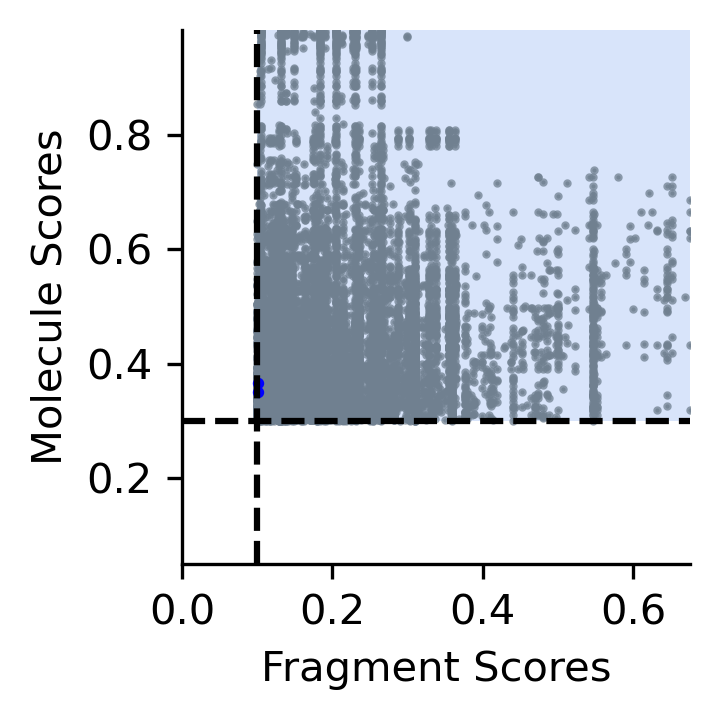

In [9]:
fig, ax = plt.subplots(figsize = (2.5,2.5), dpi = 300)
rect = patches.Rectangle((0.1, 0.3), max(frag_scos)-0.1+0.05,max(mol_scos)-0.3+0.05, alpha = 0.25, linewidth=1, facecolor='cornflowerblue')
plt.axvline(0.1, color = 'black', linestyle = '--')
plt.axhline(0.3, color = 'black', linestyle = '--')
ax.add_patch(rect)

plt.scatter(frag_scos, mol_scos, alpha = 0.75, s=1, color = 'slategrey')
plt.scatter(EX_frag_scos, EX_mol_scos, alpha = 1, s=3, color = 'blue')

plt.xlabel('Fragment Scores')
plt.ylabel('Full Compound Scores')
plt.xlim([0, max(frag_scos)])
plt.ylim([0.05, max(mol_scos)])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('../figure_panels/scatter_frag_vs_cpd_scores_NG.png')
plt.savefig('../figure_panels/scatter_frag_vs_cpd_scores_NG.svg')
plt.show()